In [1]:
"""
File:   GMM.py
Author: AARYAN KUMAR
Date:   10/17/2021
Desc:   Implementation of Custom Gaussian Mixture Model with Expectation Maximization on IRIS Data
    
"""

'\nFile:   GMM.py\nAuthor: AARYAN KUMAR\nDate:   10/17/2021\nDesc:   Implementation of Custom Gaussian Mixture Model with Expectation Maximization on IRIS Data\n    \n'

#  Importing the necessary libraries and dependencies

In [2]:
import numpy as np
import pandas as pd
from scipy import linalg
from scipy.stats import multivariate_normal
import matplotlib as mpl
import matplotlib.pyplot as plt
import warnings
from PIL import Image
import imageio
import os
from scipy import stats
import warnings
warnings.filterwarnings("ignore")

#  Creating the class for Gaussian Mixture Model

In [3]:
# ### I decided to define the Gaussian Mixture Model as  a class. Classes provide a means of bundling data and functionality together. Creating a GMM class will create a GMM type of object, allowing new instances of that type to be made. Each class instance can have attributes attached to it for maintaining its state.
# ##### The code for this Gaussian Mixture Model class is based on and inspired by the lecture notes for EEL 5840 (University of Florida) and the scikit learn classification documentation (https://scikit-learn.org/stable/supervised_learning.html#supervised-learning)


class GMM:
   

    def __init__(self, NumberofComponents, max_iter = 100, clust_names=None):    # this function initializes the GMM with the defined parameters
        
        self.NumberofComponents = NumberofComponents     # number of clusters in which the data is split 
        self.max_iter = max_iter            # number of iterations the algorithm will be executed to find the clusters. I have set thhe default value to 100, based on the lecture notes from EEL 5840
        
        if clust_names == None:              # name of clusters, should be a string of type 'abc' for cluster names "a" "b" and "c"
            self.clust_names = [f"clust{index}" for index in range(self.NumberofComponents)]
        else:
            self.clust_names = clust_names
       
        self.pi = [1/self.NumberofComponents for comp in range(self.NumberofComponents)]   # contains the fraction of the dataset for every cluster

#######################        
        
        
    def multivariate_normal(self, X, Means, Sigs):  # function to perform multivariate-normal operation. It is used in training and prediction functions of the class.
                                                                       # X is the row for which we want to calculate the distribution. Means is the array that contains the mean for each column. Sigs is a 2d array of covariance of features of dataset.
                                                                       # I did not use the predefined function for mvn because it would randomly throw errors when the dataset changes
        return (2*np.pi)**(-len(X)/2)*np.linalg.det(Sigs)**(-1/2)*np.exp(-np.dot(np.dot((X-Means).T, np.linalg.inv(Sigs)), (X-Means))/2)

#####################    
    
    def fit(self, X):     # this function trains the model. The parameter X is the 2d numpy array of dataset with columns as features and rows as sampeles
        
        new_X = np.array_split(X, self.NumberofComponents)  # Spliting the data in NumberofComponents 
        
        self.Means = [np.mean(x, axis=0) for x in new_X]  # Initializing Means
        self.Sigs = [np.cov(x.T) for x in new_X] # Initializing Sigs
        
        del new_X  # Deleting the matrix 
        
        for iteration in range(self.max_iter):
###################### ESTIMATION STEP

           
            self.r = np.zeros((len(X), self.NumberofComponents)) # Initiating the r matrix; evrey row contains the probabilities for every cluster for this row
            
            # Calculating the r matrix
            for n in range(len(X)):
                for k in range(self.NumberofComponents):
                    self.r[n][k] = self.pi[k] * self.multivariate_normal(X[n], self.Means[k], self.Sigs[k])
                    self.r[n][k] /= sum([self.pi[j]*self.multivariate_normal(X[n], self.Means[j], self.Sigs[j]) for j in range(self.NumberofComponents)])
            # Calculating the N
            N = np.sum(self.r, axis=0)
            
###################### Maximization STEP

            self.Means = np.zeros((self.NumberofComponents, len(X[0]))) # Initializing the Means as a zero vector
            
        # Updating the Means
            for k in range(self.NumberofComponents):
                for n in range(len(X)):
                    self.Means[k] += self.r[n][k] * X[n]
            self.Means = [1/N[k]*self.Means[k] for k in range(self.NumberofComponents)]
            
            self.Sigs = [np.zeros((len(X[0]), len(X[0]))) for k in range(self.NumberofComponents)] # Initiating the list of the Sigs
            
            # Updating the covariance matrices
            for k in range(self.NumberofComponents):
                self.Sigs[k] = np.cov(X.T, aweights=(self.r[:, k]), ddof=0)
            self.Sigs = [1/N[k]*self.Sigs[k] for k in range(self.NumberofComponents)]
            
            
            self.pi = [N[k]/len(X) for k in range(self.NumberofComponents)] # Updating the pi
            
        return self.Means, self.Sigs, self.pi
            
    def predict(self, X):  # this function predicts the clusters on the input X 2d array.
        
        probas = []
        for n in range(len(X)):
            probas.append([self.multivariate_normal(X[n], self.Means[k], self.Sigs[k])
                           for k in range(self.NumberofComponents)])
        cluster = []
        for proba in probas:
            cluster.append(self.clust_names[proba.index(max(proba))])
        return cluster

#  Defining the Probabilistic Generative Classifier function

In [4]:
def PGC(mu1,mu2,mu3,cov1,cov2,cov3,pC1,pC2,pC3):
    
    mu1=mu1[0:2]
    mu2=mu2[0:2]
    mu3=mu3[0:2]
    
    df=pd.read_csv('iris.csv')
    class2 = df.loc[df['classes'] == 'Iris-versicolor']
    class3 = df.loc[df['classes'] == 'Iris-virginica']
    class1 = df.loc[df['classes'] == 'Iris-setosa']
    class1 = class1.iloc[:,0:2]
    class2 = class2.iloc[:,0:2]
    class3 = class3.iloc[:,0:2]
    
    cov1 = np.cov(class1.T)
    cov2 = np.cov(class2.T)
    cov3 = np.cov(class3.T)
    
    from scipy.stats import multivariate_normal
    xd = np.linspace(-5, 4, 100)
    yd = np.linspace(-6, 6, 100)
    xm,ym = np.meshgrid(xd, yd)
    Xd = np.dstack([xm,ym])
    
    #look at the pdf for class 1
    y1 = multivariate_normal.pdf(Xd, mean=mu1, cov=cov1)
    

    #look at the pdf for class 2
    y2 = multivariate_normal.pdf(Xd, mean=mu2, cov=cov2);
    


    #look at the pdf for class 3
    y3 = multivariate_normal.pdf(Xd, mean=mu3, cov=cov3);


    #Look at the posterior for class 1
    pos1 = (y1*pC1)/(y1*pC1 + y2*pC2 + y3*pC3);


    #Look at the posterior for class 2
    pos2 = (y2*pC2)/(y1*pC1 + y2*pC2 + y3*pC3);


    #Look at the posterior for class 3
    pos3 = (y3*pC3)/(y1*pC1 + y2*pC2 + y3*pC3);

    return y1, y2, y3, pos1, pos2, pos3

#  Loading Iris Dataset

In [5]:
iris= pd.read_csv('iris.csv')
classtonumber = {'Iris-setosa': 0,'Iris-versicolor': 1,'Iris-virginica': 2};
iris.classes = [classtonumber[item] for item in iris.classes]   # changing the string values to integers so it can be loaded into numpy array
iris_data=iris.to_numpy()         

#  Visualise the data

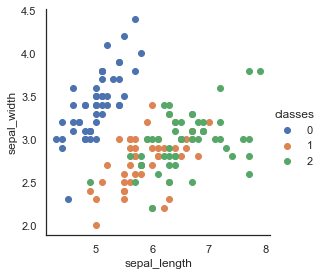

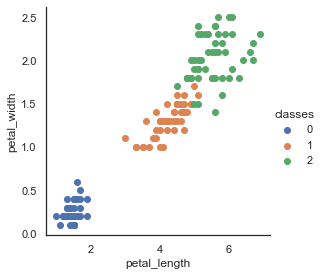

In [6]:
# #### Code based on examples on matplotlib website amd documentation




import seaborn as sns
sns.set(style="white", color_codes=True)

# use seaborn to make scatter plot showing classes with respect to sepal features
sns.FacetGrid(iris, hue="classes", size=4)    .map(plt.scatter, "sepal_length", "sepal_width")    .add_legend();

 # use seaborn to make scatter plot showing classes with respect to petal features
sns.FacetGrid(iris, hue="classes", size=4)     .map(plt.scatter, "petal_length", "petal_width")     .add_legend();

# creating feature and label arrays from the iris dataset

In [7]:
X = iris.drop(columns = ['classes']).copy()   # feature array
y = iris['classes']                           # array of true assignment of labels

# Splitting the data

In [8]:
from sklearn.model_selection import train_test_split

# Split the data in 60:20:20 for train:test:validate
training_size=0.6

# In the first step we will split the data in training and remaining dataset
X_train, X_temp, y_train, y_temp = train_test_split(X,y, train_size=training_size,random_state=8, stratify=y)

# Now since we want the valid and test size to be equal (10% each of overall data). 
# we have to define validation_size=0.5 (that is 50% of remaining data)
testing_size = 0.5
X_valid, X_test, y_valid, y_test = train_test_split(X_temp,y_temp, test_size=testing_size)

X_train=X_train.to_numpy()
X_valid=X_valid.to_numpy()
X_test=X_test.to_numpy()
y_train=y_train.to_numpy()
y_valid=y_valid.to_numpy()
y_test=y_test.to_numpy()
X=X.to_numpy()
y=y.to_numpy()

In [9]:
print('The shapes of training, validation and testing pairs are as follow :-')
print(X_train.shape)
print(y_train.shape)
print(X_valid.shape)
print(y_valid.shape)
print(X_test.shape)
print(y_test.shape)

The shapes of training, validation and testing pairs are as follow :-
(90, 4)
(90,)
(30, 4)
(30,)
(30, 4)
(30,)


# Implementation of GMM on the IRIS Dataset

In [10]:
gmm=GMM(3, max_iter = 100, clust_names='012')
Means, Sigs, Ps =gmm.fit(X)   # getting the generating distribution for the dataset


# ### Getting the generating distribution of all three classes (class0,class1,class2) of dataset




Means0 = Means[0]
Means1 = Means[1]
Means2 = Means[2]





Sigs0=Sigs[0]
Sigs1=Sigs[1]
Sigs2=Sigs[2]





Ps0=Ps[0]
Ps1=Ps[1]
Ps2=Ps[2]

# Predicting the GMM clusters for training, validation and testing dataset

In [11]:
yp_train = gmm.predict(X_train)
yp_valid = gmm.predict(X_valid)
yp_test = gmm.predict(X_test)

#Convertting the predicted output into desired datatype
yp_train=np.array(yp_train)
yp_train = yp_train.astype(np.int64)

yp_valid=np.array(yp_valid)
yp_valid = yp_valid.astype(np.int64)

yp_test=np.array(yp_test)
yp_test = yp_test.astype(np.int64)

# Defining the function to get the confusion Matrices

In [12]:
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score
def calculate_decision_metric(y_true, y_pred):
    confusion_mat = confusion_matrix(y_true, y_pred)
    pred_accu = accuracy_score(y_true, y_pred)
    return confusion_mat, pred_accu

# PLOTTING THE CLUSTERS

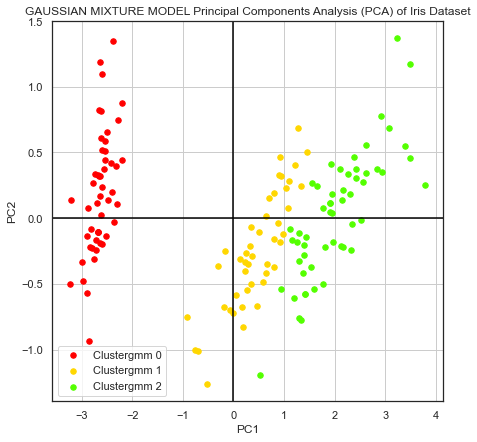

In [13]:
#As the numbers of features in the dataset are more (4d data), to avoid problems due to dimensionality while plotting, I remaped the data to a smaller coordinate system using PCA.
# By doing this, it becomes easier to plot a scatterplot for the clusters. As the data is going from only 4d to 2d, there will not be any significant loss of information.

from sklearn.decomposition import PCA

ndimensions = 2

pca = PCA(n_components=ndimensions, random_state=42)
pca.fit(X)
X_pca_array = pca.transform(X)
X_pca = pd.DataFrame(X_pca_array, columns=['PC1','PC2'])

df_plot = X_pca.copy()
y_predicted=gmm.predict(X)
y_predicted=np.array(y_predicted)
y_predicted = y_predicted.astype(np.int64)
df_plot['Clustergmm'] = y_predicted
df_plot['SpeciesId'] = y


def plotData(df, groupby):
    "make a scatterplot of the first two principal components of the data, colored by the groupby field"
    
    # make a figure with just one subplot.
    # you can specify multiple subplots in a figure, 
    # in which case ax would be an array of axes,
    # but in this case it'll just be a single axis object.
    fig, ax = plt.subplots(figsize = (7,7))

    # color map
    cmap = mpl.cm.get_cmap('prism')

    # we can use pandas to plot each cluster on the same graph.
    # see http://pandas.pydata.org/pandas-docs/stable/generated/pandas.DataFrame.plot.html
    for i, cluster in df.groupby(groupby):
        cluster.plot(ax = ax, # need to pass this so all scatterplots are on same graph
                     kind = 'scatter', 
                     x = 'PC1', y = 'PC2',
                     color = cmap(i/(3-1)), # cmap maps a number to a color
                     label = "%s %i" % (groupby, i), 
                     s=30) # dot size
    ax.grid()
    ax.axhline(0, color='black')
    ax.axvline(0, color='black')
    ax.set_title("GAUSSIAN MIXTURE MODEL Principal Components Analysis (PCA) of Iris Dataset");




plotData(df_plot, 'Clustergmm')

# Implementing the generating distribution in my PGC

Text(0.5, 1.0, 'CLASS2 - decision boundary')

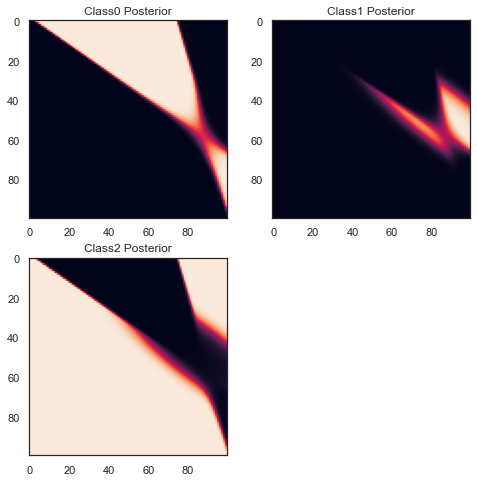

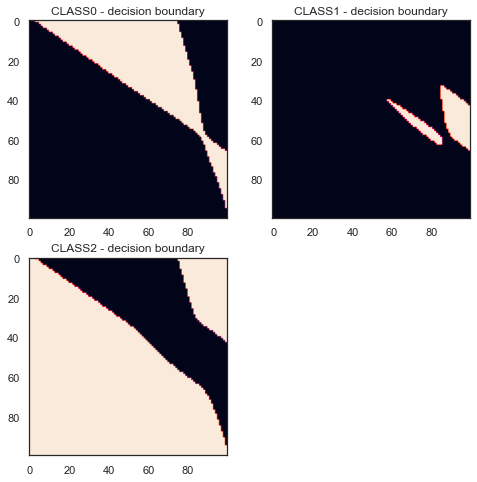

In [14]:
pdf0, pdf1, pdf2, pos0, pos1, pos2 = PGC(Means0,Means1,Means2,Sigs0,Sigs1,Sigs2,Ps0,Ps1,Ps2)

# Plot the Posterior of the three classes

plt.figure(figsize=(8, 8))
plt.subplot(221)
plt.imshow(pos0)
plt.title('Class0 Posterior')
plt.subplot(222)
plt.imshow(pos1)
plt.title('Class1 Posterior')
plt.subplot(223)
plt.imshow(pos2)
plt.title('Class2 Posterior')

#Look at the decision boundary

plt.figure(figsize=(8, 8))
plt.subplot(221)
plt.imshow(pos0>(pos2+pos1))
plt.title('CLASS0 - decision boundary')
plt.subplot(222)
plt.imshow(pos1>(pos0+pos2))
plt.title('CLASS1 - decision boundary')
plt.subplot(223)
plt.imshow(pos2>(pos0+pos1))
plt.title('CLASS2 - decision boundary')

#  Getting the confusion matrices for training, validation and testing data

In [15]:
con_train, accu_train = calculate_decision_metric(y_train, yp_train)
con_valid, accu_valid = calculate_decision_metric(y_valid, yp_valid)
con_test, accu_test = calculate_decision_metric(y_test, yp_test)




print('The confusion matrix for training data is as follows \n',con_train)

print('The confusion matrix for validation data is as follows \n',con_valid)

print('The confusion matrix for testing data is as follows \n',con_test )

The confusion matrix for training data is as follows 
 [[30  0  0]
 [ 0 29  1]
 [ 0  0 30]]
The confusion matrix for validation data is as follows 
 [[11  0  0]
 [ 0  7  2]
 [ 0  0 10]]
The confusion matrix for testing data is as follows 
 [[ 9  0  0]
 [ 0  9  2]
 [ 0  0 10]]
